# Benchmarking `squint`

In [ ]:
import itertools
import timeit
from functools import partial
from typing import Literal

import equinox as eqx
import jax
import jax.numpy as jnp
import polars as pl
import seaborn as sns
from beartype import beartype
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import Conditional, DiscreteVariableState, HGate, Phase, XGate

In [ ]:
def circuit_factory(dim: int, n: int, n_phi: int, depth: int):
    circuit = Circuit()
    for i in range(n):
        circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

    circuit.add(HGate(wires=(0,)))
    for i in range(n - 1):
        circuit.add(Conditional(gate=XGate, wires=(i, i + 1)))

    block_width = n // n_phi
    for k, phi in enumerate(range(n_phi)):
        wires = [i + k * block_width for i in (range(1, block_width))]

        circuit.add(
            SharedGate(
                op=Phase(wires=(k * block_width,), phi=0.1 * jnp.pi), wires=tuple(wires)
            ),
            f"phase{k}",
        )

    for ell in range(depth):
        for i in range(n):
            circuit.add(HGate(wires=(i,)))

    for i in range(n):
        circuit.add(HGate(wires=(i,)))

    get = lambda pytree: jnp.array(
        [pytree.ops[f"phase{k}"].op.phi for k in range(n_phi)]
    )

    return circuit, get


circuit, get = circuit_factory(dim=2, n=2, n_phi=1, depth=2)
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=2, optimize="greedy")

pprint(circuit)

Circuit(
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   DiscreteVariableState(wires=(1,), n=[(1.0, (0,))]),
│   2:
│   HGate(wires=(0,)),
│   3:
│   Conditional(wires=(0, 1), gate=XGate(wires=(1,))),
│   'phase0':
│   SharedGate(
│     wires=(0, 1),
│     op=Phase(wires=(0,), phi=weak_f32[]),
│     copies=[Phase(wires=(1,), phi=None)],
│     where=<function <lambda>>,
│     get=<function <lambda>>
│   ),
│   5:
│   HGate(wires=(0,)),
│   6:
│   HGate(wires=(1,)),
│   7:
│   HGate(wires=(0,)),
│   8:
│   HGate(wires=(1,)),
│   9:
│   HGate(wires=(0,)),
│   10:
│   HGate(wires=(1,))
  }
)


In [ ]:
@beartype
def benchmark(
    dim: int, n: int, n_phi: int, depth: int, jit: bool, device: Literal["cpu", "gpu"]
):
    circuit, get = circuit_factory(dim, n, n_phi, depth)
    params, static = eqx.partition(circuit, eqx.is_inexact_array)
    sim = circuit.compile(params, static, dim=dim, optimize="greedy")
    if jit:
        sim = sim.jit(device=jax.devices(device)[0])

    times = {
        "prob.forward": timeit.Timer(partial(sim.probabilities.forward, params)).repeat(3, 1),
        "prob.grad": timeit.Timer(partial(sim.probabilities.grad, params)).repeat(3, 1),
        "prob.cfim": timeit.Timer(partial(sim.probabilities.cfim, get, params)).repeat(3, 1),
    }
    return {
        "dim": dim,
        "n": n,
        "n_phi": n_phi,
        "depth": depth,
        "jit": jit,
        "device": device,
        "max(prob.forward)": max(times["prob.forward"]),
        "max(prob.grad)": max(times["prob.grad"]),
        "max(prob.cfim)": max(times["prob.cfim"]),
        "min(prob.forward)": min(times["prob.forward"]),
        "min(prob.grad)": min(times["prob.grad"]),
        "min(prob.cfim)": min(times["prob.cfim"]),
    }


def batch(dims, ns, n_phis, depths, jits, devices):
    df = []
    config = list(itertools.product(dims, ns, n_phis, depths, jits, devices))
    for i, (dim, n, n_phi, depth, jit, device) in enumerate(config):
        print(dim, n, n_phi, depth, jit, device)
        df.append(benchmark(dim, n, n_phi, depth, jit, device))
    return pl.DataFrame(df)

In [ ]:
df1 = batch(
    dims=(1, 2, 3, 4), ns=(4,), n_phis=(1,), depths=(0,), jits=(True,), devices=("cpu",)
)

1 4 1 0 True cpu


2 4 1 0 True cpu


3 4 1 0 True cpu


4 4 1 0 True cpu


In [ ]:
# df1.hvplot.scatter(x="dim", y="min(prob.forward)")

In [ ]:
df2 = batch(
    dims=(2,),
    ns=list(range(2, 16)),
    n_phis=(2,),
    depths=(0,),
    jits=(True, False),
    devices=("cpu", "gpu"),
)

2 2 2 0 True cpu


2 2 2 0 True gpu


2 2 2 0 False cpu


2 2 2 0 False gpu


2 3 2 0 True cpu


2 3 2 0 True gpu


2 3 2 0 False cpu


2 3 2 0 False gpu


2 4 2 0 True cpu


2 4 2 0 True gpu


2 4 2 0 False cpu


2 4 2 0 False gpu


2 5 2 0 True cpu


2 5 2 0 True gpu


2 5 2 0 False cpu


2 5 2 0 False gpu


2 6 2 0 True cpu


2 6 2 0 True gpu


2 6 2 0 False cpu


2 6 2 0 False gpu


2 7 2 0 True cpu


2 7 2 0 True gpu


2 7 2 0 False cpu


2 7 2 0 False gpu


2 8 2 0 True cpu


2 8 2 0 True gpu


2 8 2 0 False cpu


2 8 2 0 False gpu


2 9 2 0 True cpu


2 9 2 0 True gpu


2 9 2 0 False cpu


2 9 2 0 False gpu


2 10 2 0 True cpu


2 10 2 0 True gpu


2 10 2 0 False cpu


2 10 2 0 False gpu


2 11 2 0 True cpu


2 11 2 0 True gpu


2 11 2 0 False cpu


2 11 2 0 False gpu


2 12 2 0 True cpu


2 12 2 0 True gpu


2 12 2 0 False cpu


2 12 2 0 False gpu


2 13 2 0 True cpu


2 13 2 0 True gpu


2 13 2 0 False cpu


2 13 2 0 False gpu


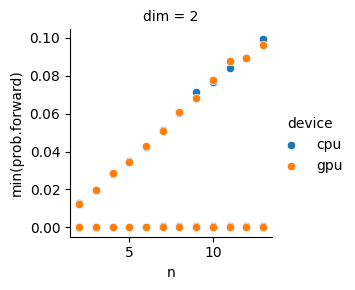

In [ ]:
_g = sns.FacetGrid(df2, row="jit", col="jit", hue="device")
_g.map(sns.lineplot, "n", "min(prob.cfim)", markers="o")
_g.add_legend()

In [ ]:
df3 = batch(
    dims=(2, 3, 4),
    ns=list(range(2, 6)),
    n_phis=(1,),
    depths=(0,),
    jits=(True, False),
    devices=("cpu", "gpu"),
    # devices = ('cpu', )
)

2 2 1 0 True cpu


2 2 1 0 True gpu


2 2 1 0 False cpu


2 2 1 0 False gpu


2 3 1 0 True cpu


2 3 1 0 True gpu


2 3 1 0 False cpu


2 3 1 0 False gpu


2 4 1 0 True cpu


2 4 1 0 True gpu


2 4 1 0 False cpu


2 4 1 0 False gpu


2 5 1 0 True cpu


2 5 1 0 True gpu


2 5 1 0 False cpu


2 5 1 0 False gpu


3 2 1 0 True cpu


3 2 1 0 True gpu


3 2 1 0 False cpu


3 2 1 0 False gpu


3 3 1 0 True cpu


3 3 1 0 True gpu


3 3 1 0 False cpu


3 3 1 0 False gpu


3 4 1 0 True cpu


3 4 1 0 True gpu


3 4 1 0 False cpu


3 4 1 0 False gpu


3 5 1 0 True cpu


3 5 1 0 True gpu


3 5 1 0 False cpu


3 5 1 0 False gpu


4 2 1 0 True cpu


4 2 1 0 True gpu


4 2 1 0 False cpu


4 2 1 0 False gpu


4 3 1 0 True cpu


4 3 1 0 True gpu


4 3 1 0 False cpu


4 3 1 0 False gpu


4 4 1 0 True cpu


4 4 1 0 True gpu


4 4 1 0 False cpu


4 4 1 0 False gpu


4 5 1 0 True cpu


4 5 1 0 True gpu


4 5 1 0 False cpu


4 5 1 0 False gpu


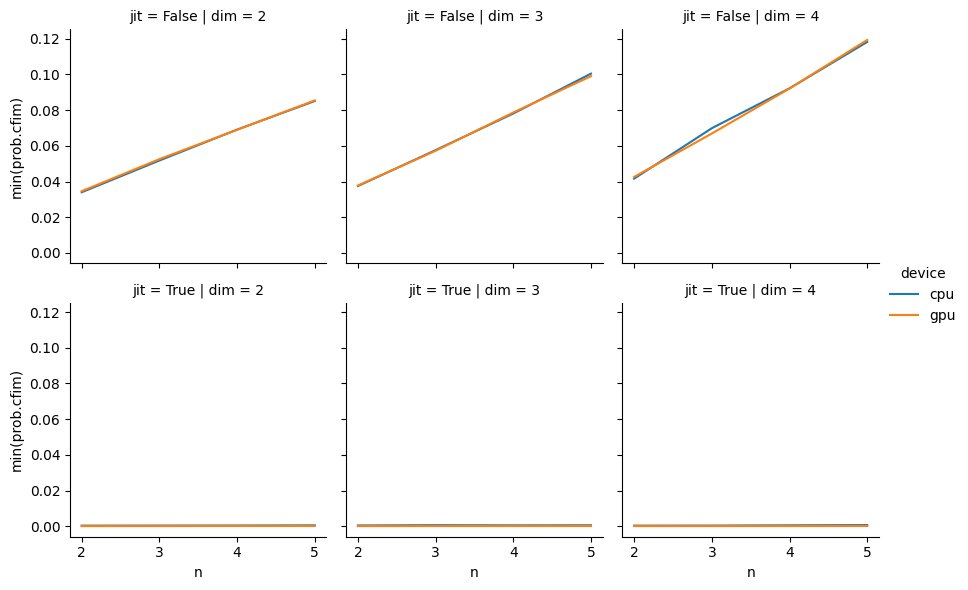

In [ ]:
_g = sns.FacetGrid(df3, row="jit", col="dim", hue="device")
_g.map(sns.lineplot, "n", "min(prob.cfim)", markers="o")
_g.add_legend()

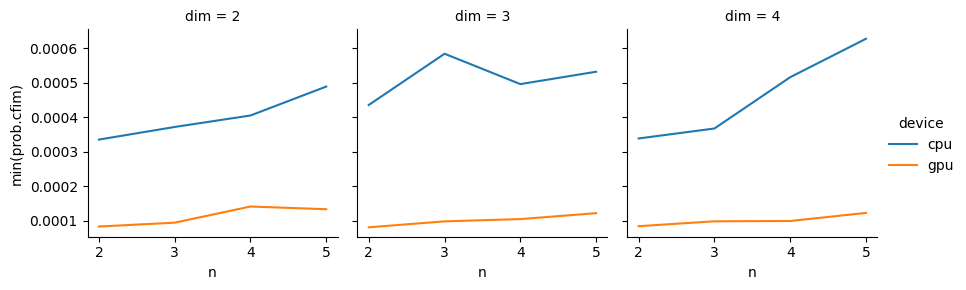

In [ ]:
_g = sns.FacetGrid(df3.filter(pl.col("jit") == True), col="dim", hue="device")
_g.map(sns.lineplot, "n", "min(prob.cfim)", markers="o")
_g.add_legend()